In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [6]:
anno_df = pd.read_csv(
    DATA_DIR / "celeba" / "CelebAMask-HQ" / "CelebAMask-HQ-attribute-anno.txt",
    header=1,
    delimiter=" ",
)
anno_df["id"] = [int(i[0].split(".")[0]) for i in anno_df.index.values]

In [7]:
hair_types = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bald']
# make a category for hair color
anno_df['hair_category'] = None
for idx, row in tqdm(anno_df.iterrows(), total = len(anno_df)):
    hair_idx = np.where(row[hair_types] == 1)[0]
    if len(hair_idx) == 1:
        anno_df.loc[idx, 'hair_category']= hair_idx[0]
    elif len(hair_idx) > 1: 
        anno_df.loc[idx, 'hair_category']= -1
    else:
        anno_df.loc[idx, 'hair_category']= -2

In [8]:
print(list(anno_df.columns))

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'id', 'hair_category']


In [9]:
faces_32_df = pd.read_pickle(DATA_DIR / 'celeba' / 'faces_32.pickle')

In [10]:
faces_32_df = pd.merge(faces_32_df, anno_df[['id', 'hair_category']], on=['id'])

In [11]:
len(faces_32_df)

30000

In [12]:
faces_32_df['subset'] = 'train'
faces_32_df.loc[0:1000, 'subset'] = 'valid'
faces_32_df.loc[1000:1999, 'subset'] = 'test'

In [13]:
faces_32_df[:3]

,face,id,hair_category,subset
0,"[[[63, 63, 63], [63, 63, 63], [63, 63, 63], [6...",20142,0,valid
1,"[[[63, 63, 63], [63, 63, 63], [63, 63, 63], [6...",8126,1,valid
2,"[[[63, 63, 63], [63, 63, 63], [63, 63, 63], [6...",12655,0,valid


In [14]:
faces_32_df[-1:]

,face,id,hair_category,subset
29999,"[[[64, 64, 64], [64, 64, 64], [70, 71, 71], [9...",17714,0,train


In [15]:
{hair_types[int(i)]:np.sum(faces_32_df['hair_category'] == i) for i in faces_32_df.hair_category.unique() if i in [0, 1,2,3,4]}

{'Black_Hair': 6486, 'Blond_Hair': 4958, 'Bald': 706, 'Brown_Hair': 6657}

In [16]:
Y_train = np.array(list(faces_32_df.hair_category.values[faces_32_df.subset == 'train'])).astype('float32')
Y_valid = np.array(list(faces_32_df.hair_category.values[faces_32_df.subset == 'valid'])).astype('float32')
Y_test = np.array(list(faces_32_df.hair_category.values[faces_32_df.subset == 'test'])).astype('float32')

In [17]:
X_train = np.array(list(faces_32_df.face.values[faces_32_df.subset == 'train'])) / 255.
X_valid = np.array(list(faces_32_df.face.values[faces_32_df.subset == 'valid'])) / 255.
X_test = np.array(list(faces_32_df.face.values[faces_32_df.subset == 'test'])) / 255.

In [18]:
np.array(list(faces_32_df.face.values[faces_32_df.subset == 'train'])).shape

(28000, 32, 32, 3)

In [19]:
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))

In [20]:
X_train_flat.shape, X_valid.shape, X_test.shape

((28000, 3072), (1000, 32, 32, 3), (1000, 32, 32, 3))

### define networks

In [21]:
dims = (32,32,3)
n_components = 2

In [22]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

In [23]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=4 * 4 * 256, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(4, 4, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=3, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    )
])

### Create model and train

In [24]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=1,
    encoder=encoder,
    decoding_method="autoencoder", 
    decoder=decoder,
    valid_X = X_valid,
    valid_Y = Y_valid,
    dims = dims
)

In [25]:
z = embedder.fit_transform(X_train_flat)

tfUMAP(decoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f4714fe8a58>,
       decoding_method='autoencoder', dims=(32, 32, 3),
       encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f47175308d0>,
       negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f4714fc6c50>,
       tensorboard_logdir='/tmp...
        0., -2.,  0., -2., -2., -2., -2., -2.,  0., -2.,  0.,  2.,  0.,
        1.,  0., -2., -2., -2.,  0.,  2., -2.,  3.,  1.,  0.,  0.,  2.,
        1., -2.,  2., -2.,  0.,  2.,  1., -2.,  1.,  2., -2.,  0., -2.,
        2.,  1.,  1.,  2., -2., -2., -2., -2.,  0., -2.,  2.,  0.,  1.,
        2.,  1., -2., -2.,  0., -2., -2., -2., -2.,  2.,  1., -2., -2.,
       -2.,  1., -2., -2., -2., -2.,  2.,  0., -2.,  3.,  0.,  0., -2.,
       -2.,  0., -2., -2.,  2.,  2., -2., -2.,  2.,  2.,  0.,  1., -2.,
       -2.,  2.,  0.,  0.,  2., -2.,  0.,  0.,  2.,  2.,  0., -2.],
      dtype=float32))


W0707 12:45:53.835232 139946322499392 base_layer.py:1790] Layer conv2d is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Tue Jul  7 12:45:53 2020 Finished embedding


### Plot model output

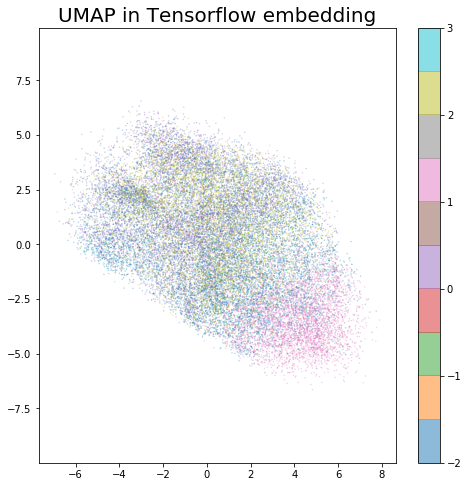

In [26]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [27]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [28]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss', 'recon_loss']
['recon_loss']


,wall_time,step,val,group,variable
0,1.594151e+09,1,6.561552,train,umap_loss
1,1.594151e+09,2,5.118960,train,umap_loss
2,1.594151e+09,3,4.042151,train,umap_loss


In [29]:
loss_df.group.unique()

array(['train', 'valid'], dtype=object)

Text(0.5, 1.0, 'Reconstruction loss')

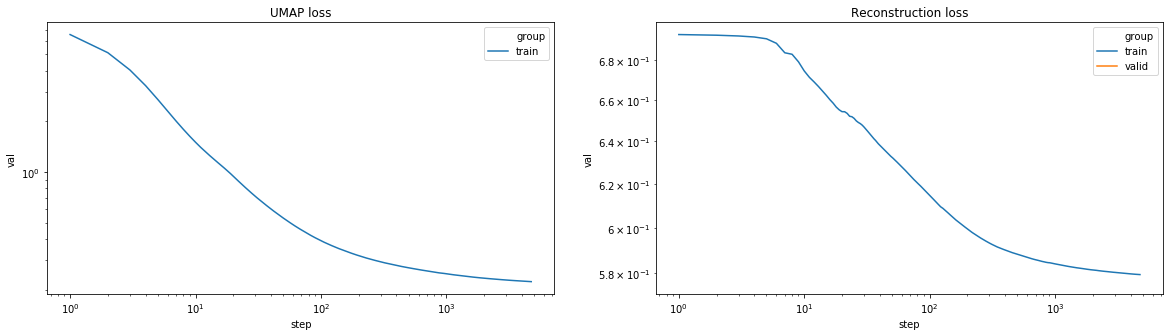

In [38]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
ax = axs[0]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'], ax = ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('UMAP loss')

ax = axs[1]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='recon_loss'], ax = ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Reconstruction loss')

### View reconstructions on test data

In [31]:
z_test = embedder.transform(X_test)

In [32]:
X_test_recon = embedder.inverse_transform(z_test)

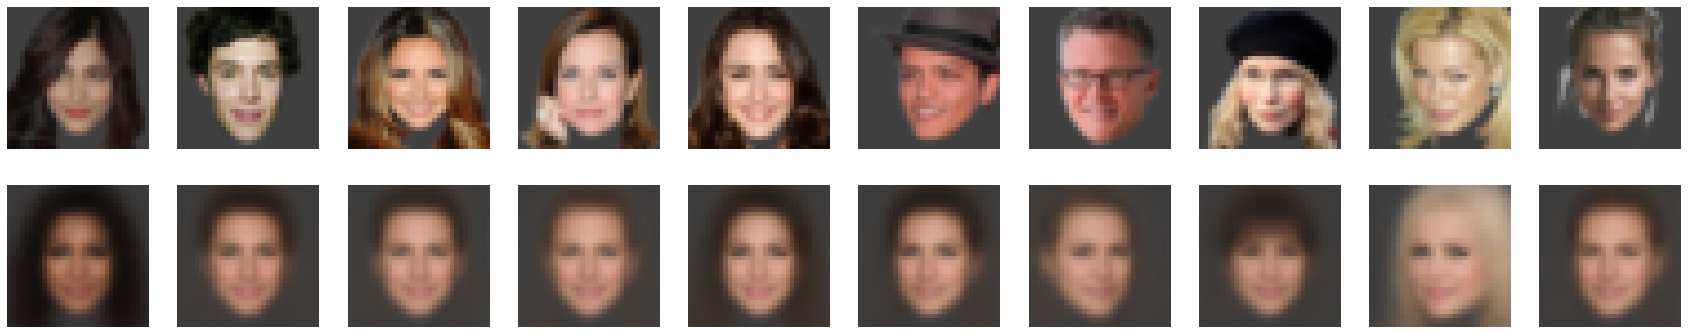

In [35]:
nex = 10
fig, axs = plt.subplots(ncols=nex, nrows=2, figsize=(nex*3,2*3))
for i in range(nex):
    axs[0,i].imshow(X_test[i].reshape(32,32,3))
    axs[1,i].imshow(X_test_recon[i].reshape(32,32,3))
for ax in axs.flatten():
    ax.axis('off')

In [ ]:
### Interpolations on test data